In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import parse_runs

In [2]:
runs_df, runs_segments = parse_runs.load_and_process_json('data/dynamic_log_advanced_4.json')

print(runs_df.columns)

by_scenario = {}

for ((run_i,run),segments) in zip(runs_df.iterrows(),runs_segments):
    by_scenario.setdefault((run['n_total'],run['n_discoverable'],run['visibility_model']), []).append((run,segments))

Index(['planner', 'n_discoverable', 'n_false', 'n_given', 'n_total',
       'visibility_model', 'discoverable', 'false_positives',
       'known_unvisited', 'total', 'visited', 'n_visited', 'time',
       'total_experiment_runtime', 'total_path_length', 'length_per_visited',
       'time_per_visited'],
      dtype='object')


/usr/lib/python3/dist-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/werner/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1220: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/werner/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1227: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/werner/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1235: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/werner/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1236: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/werner/.local/lib/python3.10/site-packages/mat

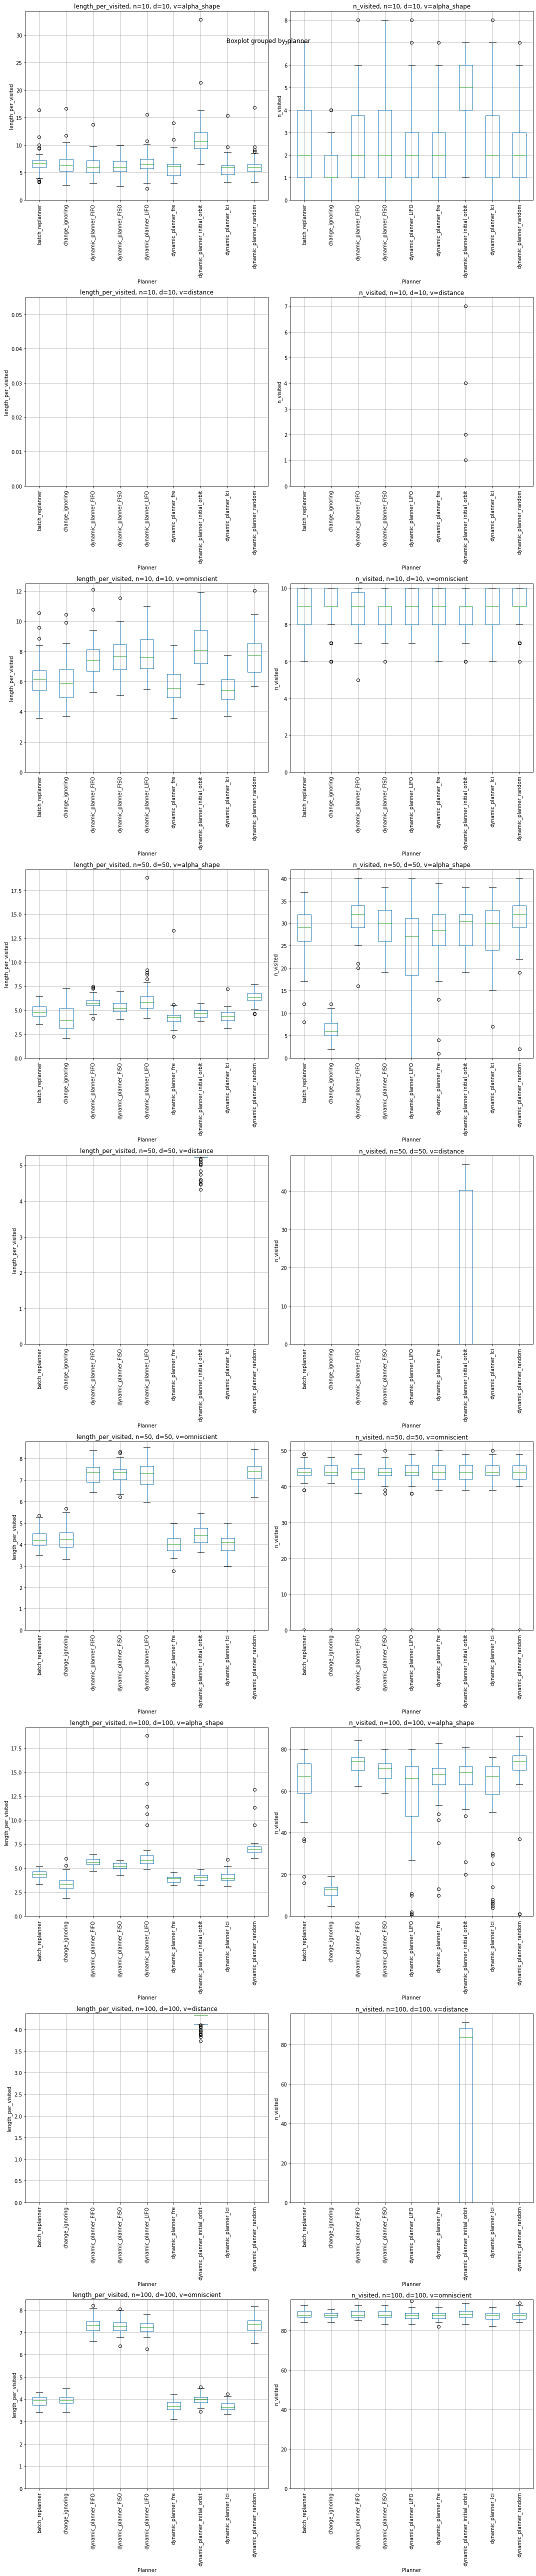

In [3]:
parse_runs.make_boxplots(runs_df)

In [11]:
def interp(input_df, new_index):
    """Return a new DataFrame with all columns values interpolated
    to the new_index values."""
    output_df = pd.DataFrame(index=new_index)
    output_df.index.name = input_df.index.name

    for colname, col in input_df.iteritems():
        output_df[colname] = np.interp(new_index, input_df.index, col)

    return output_df

def create_empty_segments_dataframe():
    """
    Create an empty DataFrame with specified columns for path_length, time,
    goals_discovered, and goals_visited.
    
    Returns:
        pd.DataFrame: Empty DataFrame with specified columns.
    """
    return pd.DataFrame([{
        'path_length': 0,
        'time': 0,
        'goals_discovered': 0,
        'goals_visited': 0
    }])

def calculate_cumulative_segments(segments, lmax):
    """
    Calculate the cumulative sum of the segments DataFrame and interpolate
    the results.
    
    Args:
        segments (pd.DataFrame): DataFrame containing the segments data.
    
    Returns:
        pd.DataFrame: DataFrame with interpolated cumulative sum of segments.
    """
    segments = segments.copy()

    if len(segments) == 0:
        segments = create_empty_segments_dataframe()

    segments_cumulative = segments.cumsum().set_index('path_length')[['goals_discovered', 'goals_visited']]

    segments_cumulative = interp(segments_cumulative, np.linspace(0, lmax, 101)).reset_index()

    return segments_cumulative

def build_cumulative_by_scenario(by_scenario):
    """
    Build a dictionary containing the cumulative data for each scenario.
    
    Args:
        by_scenario (dict): Dictionary containing the scenario data.
    
    Returns:
        dict: Dictionary with cumulative data for each scenario.
    """
    cumulative_by_scenario = {}

    for (params, scenario_runs) in by_scenario.items():

        all_segments_cumulative = {}

        for (run_data, segments) in scenario_runs:
            
            max_l = {
                10: 80,
                50: 300,
                100: 400
            }[run_data['n_total']]
            
            segments_cumulative = calculate_cumulative_segments(segments,max_l)
            all_segments_cumulative.setdefault(run_data['planner'], []).append(segments_cumulative)

        cumulative_by_scenario[params] = all_segments_cumulative

    return cumulative_by_scenario

cumulative_by_scenario = build_cumulative_by_scenario(by_scenario)

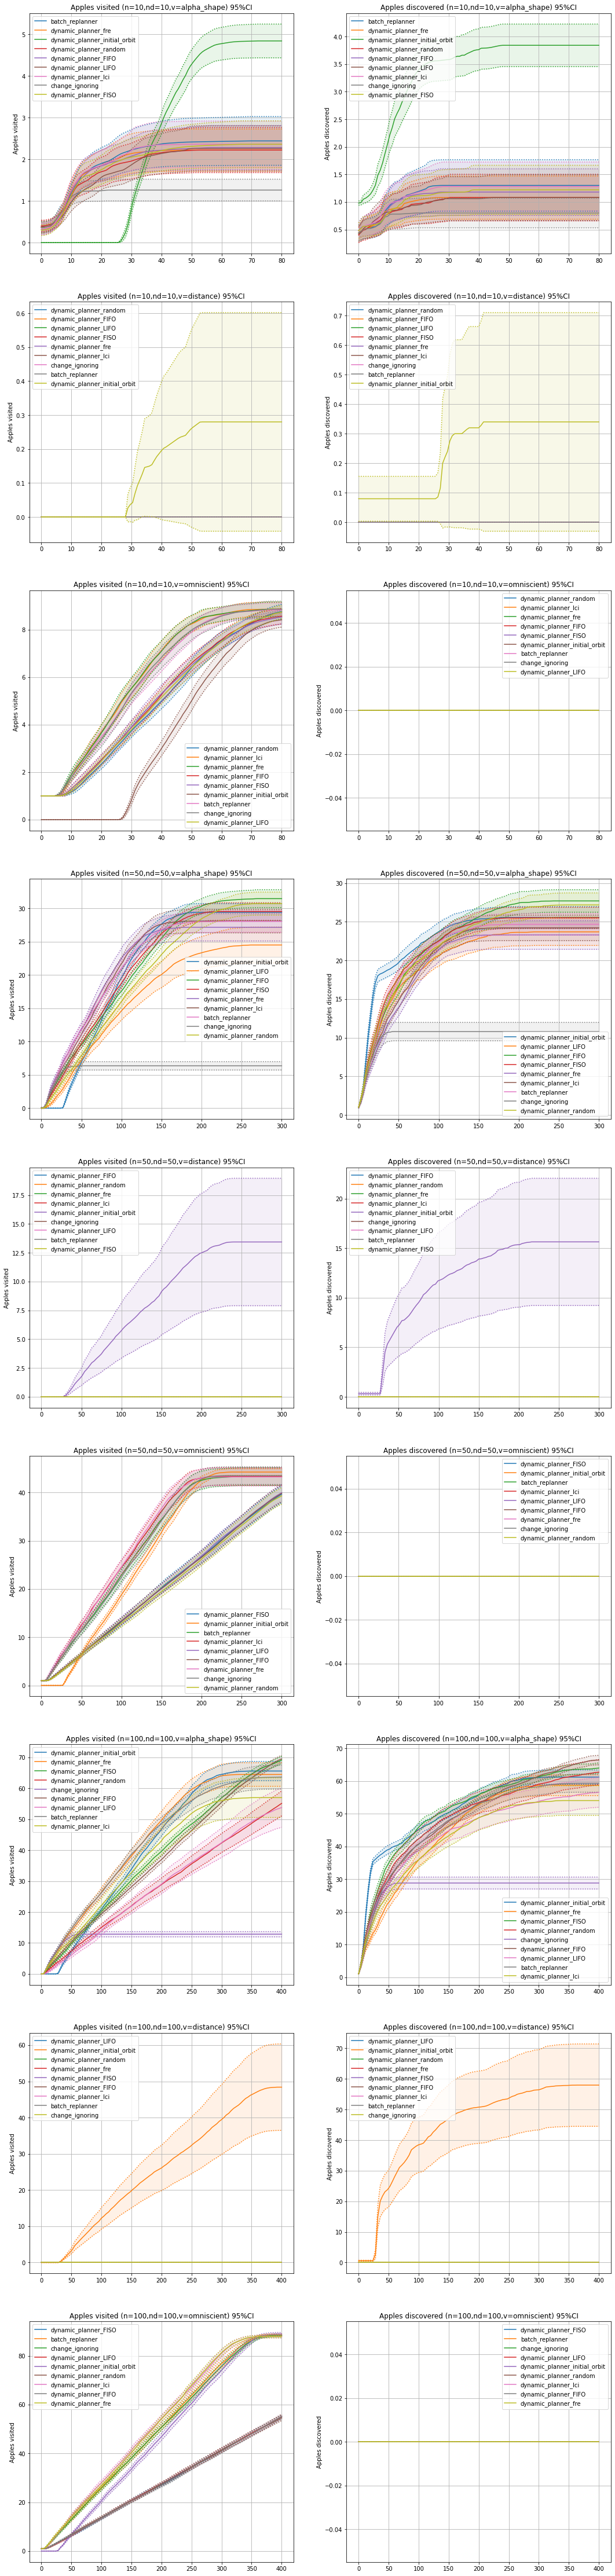

In [25]:
def plot_ci(ax, data, column, label):
    """
    Plot the 95% confidence interval for the given data and column.

    Args:
        ax (matplotlib.axes.Axes): The Axes instance to plot on.
        data (pd.DataFrame): The DataFrame containing the data to plot.
        column (str): The column name for the data to plot.
        color (str): The color of the plot line and confidence interval.
        label (str): The label for the plot.
    """
    ci_95 = data[column]['sem'] * 1.96
    line, = ax.plot(data.index, data[column]['mean'], label=label)
    ax.fill_between(data.index, (data[column]['mean'] - ci_95), (data[column]['mean'] + ci_95), alpha=0.1, color=line.get_color())
    ax.plot(data.index, (data[column]['mean'] - ci_95), linestyle=':', color=line.get_color())
    ax.plot(data.index, (data[column]['mean'] + ci_95), linestyle=':', color=line.get_color())
    
def plot_iqr(ax, data, column, label):
    """
    Plot the interquartile range (IQR) for the given data and column.

    Args:
        ax (matplotlib.axes.Axes): The Axes instance to plot on.
        data (pd.DataFrame): The DataFrame containing the data to plot.
        column (str): The column name for the data to plot.
        color (str): The color of the plot line and IQR.
        label (str): The label for the plot.
    """
    q1 = data[column]['25%']
    q3 = data[column]['75%']
    line, = ax.plot(data.index, data[column]['mean'], label=label)
    ax.fill_between(data.index, q1, q3, alpha=0.1, color=line.get_color())
    ax.plot(data.index, q1, linestyle=':', color=line.get_color())
    ax.plot(data.index, q3, linestyle=':', color=line.get_color())


def configure_axes(ax, ylabel, title):
    """
    Configure the axes with the provided ylabel and title.

    Args:
        ax (matplotlib.axes.Axes): The Axes instance to configure.
        ylabel (str): The y-axis label.
        title (str): The title for the plot.
    """
    ax.legend()
    ax.grid()
    ax.set_ylabel(ylabel)
    ax.set_title(title)

n_scenarios = len(cumulative_by_scenario)

fig, axes = plt.subplots(n_scenarios, 2, figsize=(18, 9 * n_scenarios))

from collections import OrderedDict

for ((params, by_planner), ax_row) in zip(sorted(cumulative_by_scenario.items()), axes):

    for (planner, cumul) in by_planner.items():

        d = pd.concat(cumul).groupby('path_length').agg(['mean', 'sem'])

        plot_ci(ax_row[0], d, 'goals_visited', planner)
        plot_ci(ax_row[1], d, 'goals_discovered', planner)

    configure_axes(ax_row[0], 'Apples visited', 'Apples visited (n={},nd={},v={}) 95%CI'.format(*params))
    configure_axes(ax_row[1], 'Apples discovered', 'Apples discovered (n={},nd={},v={}) 95%CI'.format(*params))

plt.show()


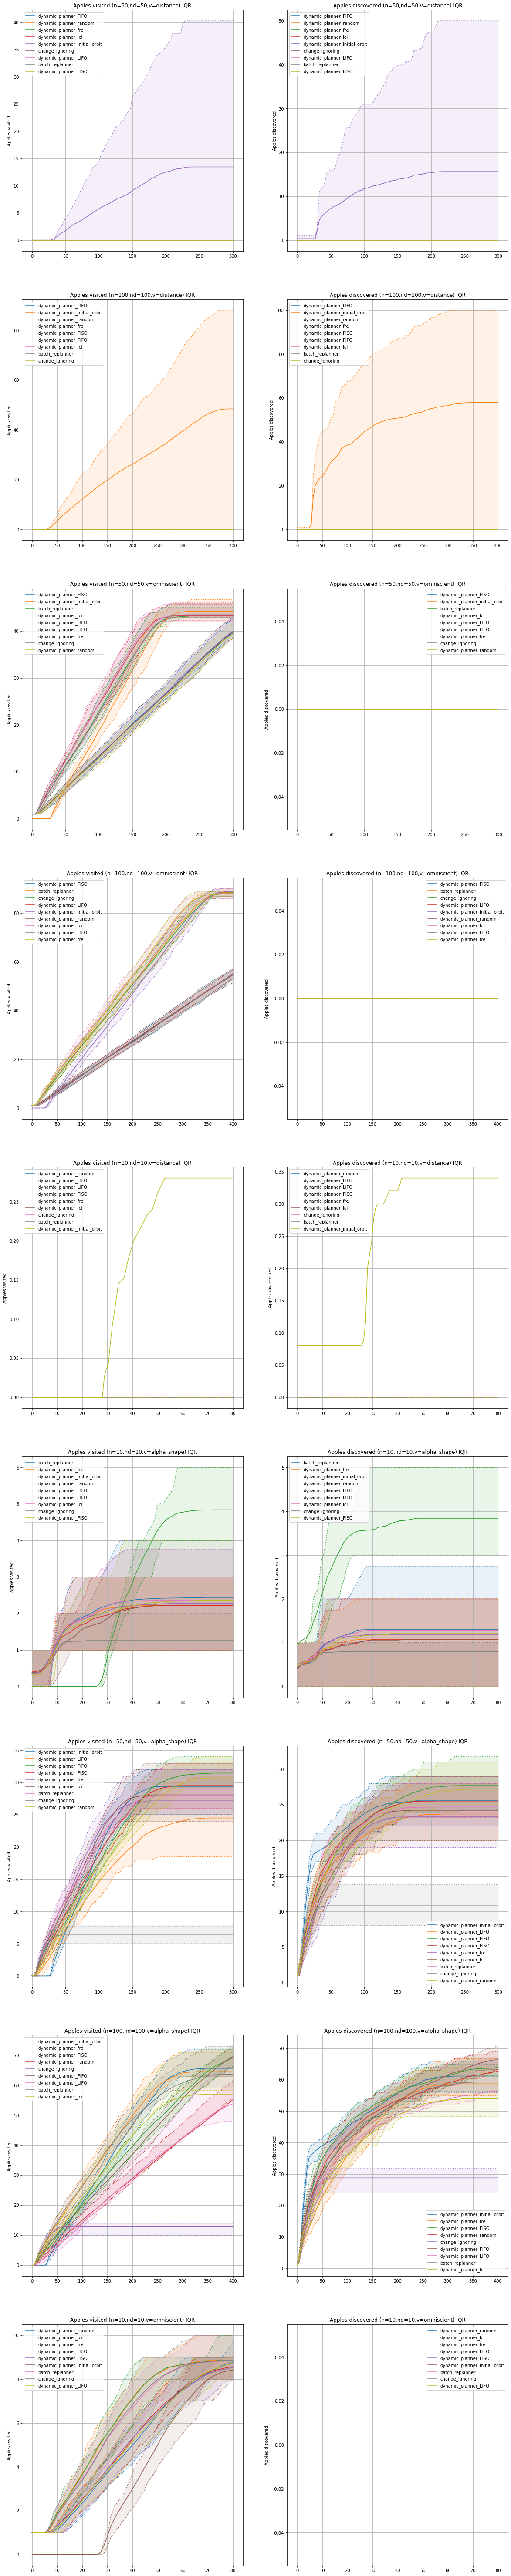

In [13]:
n_scenarios = len(cumulative_by_scenario)

fig, axes = plt.subplots(n_scenarios, 2, figsize=(20, 12 * n_scenarios))

for ((params, by_planner), ax_row) in zip(cumulative_by_scenario.items(), axes):

    for (planner, cumul) in by_planner.items():

        d = pd.concat(cumul).groupby('path_length').agg(['mean'])
        d['goals_visited', '25%'] = pd.concat(cumul).groupby('path_length')['goals_visited'].quantile(0.25)
        d['goals_visited', '75%'] = pd.concat(cumul).groupby('path_length')['goals_visited'].quantile(0.75)
        d['goals_discovered', '25%'] = pd.concat(cumul).groupby('path_length')['goals_discovered'].quantile(0.25)
        d['goals_discovered', '75%'] = pd.concat(cumul).groupby('path_length')['goals_discovered'].quantile(0.75)

        plot_iqr(ax_row[0], d, 'goals_visited', planner)
        plot_iqr(ax_row[1], d, 'goals_discovered', planner)

    configure_axes(ax_row[0], 'Apples visited', 'Apples visited (n={},nd={},v={}) IQR'.format(*params))
    configure_axes(ax_row[1], 'Apples discovered', 'Apples discovered (n={},nd={},v={}) IQR'.format(*params))